In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from pyquest import Register, Circuit
from pyquest.unitaries import X,Y,Z,H,Rx,Ry,Rz,Phase,Swap
from pyquest.operators import MatrixOperator, DiagonalOperator
from pyquest.gates import M

from qubitization import Qubitization
from qsp import QspWithQubitization
from eigensolver import NumpyEigensolver
from utility import read_file

In [6]:
def generate_H(unitaries, targets, coefficients):
    n_qubits_syst = max([max(t) for t in targets])+1
    H = []
    for i in range(len(unitaries)):
        if unitaries[i]==X: H.append(coefficients[i] * unitaries[i](targets[i]).as_matrix(n_qubits_syst))
        else: H.append(coefficients[i] * Circuit([unitaries[i](target) for target in targets[i]]).as_matrix(n_qubits_syst)) # Y([0,1]) not implemented but same as Circuit([Y(0),Y(1)])
    return H

def linear_regression(xs,ys):
    f = lambda x,a,b: a*x+b
    mask = ~(np.isnan(ys) + np.isinf(ys))
    xs_reduced = xs[mask]
    ys_reduced = ys[mask]
    return scipy.optimize.curve_fit(f, xs_reduced, ys_reduced)[0][0]

def find_linear_depenpency_coefficients(deltas):
    N = len(deltas)
    D = np.array(deltas).T
    D = np.concatenate([[np.ones(N)],D],axis=0)
    b = np.zeros(N)
    # print(D.shape, b.shape)
    b[0] = 1
    b = b.T
    # print(D.shape)
    lambdas = np.linalg.lstsq(D,b,rcond=True)[0] # returns least-squares solution with minimum norm
    return lambdas, np.allclose(deltas.T@lambdas,0) and np.allclose(sum(lambdas),1)

def find_linear_depenpency_coefficients(vectors):
    nk,n = vectors.shape
    # D = np.array(vectors)
    D = np.array(vectors).T
    D = np.concatenate([[np.ones(nk)],D],axis=0)
    # D = D.T
    b = np.zeros(n+1)
    b[0] = 1
    lambdas = np.linalg.lstsq(D,b,rcond=True)[0] # returns least-squares solution with minimum norm
    return lambdas, np.allclose(vectors.T@lambdas,0) and np.allclose(sum(lambdas),1)

In [7]:
n_part = 4

"""Ising model"""
unitaries = [Z for _ in range(n_part)] + [X for _ in range(n_part-1)]
targets = [[i] for i in range(n_part)] + [[i,i+1] for i in range(n_part-1)]
coefficients = np.random.random(2*n_part-1)

"""Heisenberg model"""
# unitaries = [Z for _ in range(n_part)] + [X for _ in range(n_part-1)] + [Y for _ in range(n_part-1)] + [Z for _ in range(n_part-1)]
# targets = [[i] for i in range(n_part)] + [[i,i+1] for i in range(n_part-1)] + [[i,i+1] for i in range(n_part-1)] + [[i,i+1] for i in range(n_part-1)]
# coefficients = np.random.random(4*n_part-3)

T = 5

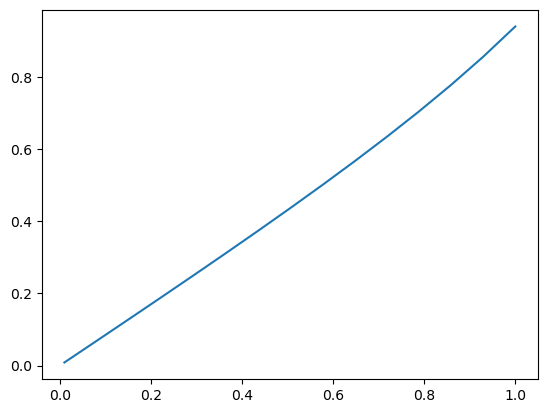

In [8]:
Hlist = generate_H(unitaries, targets, coefficients)
H = sum(Hlist)
Ha = sum(Hlist[::2])
Hb = sum(Hlist[1::2])

# print(Ha@Hb - Hb@Ha)

delta_ts = np.linspace(.01,1,15)
res = []

for deltaT in delta_ts:
    Hprime = 1j/deltaT * scipy.linalg.logm(scipy.linalg.expm(-1j*Ha*deltaT) @ scipy.linalg.expm(-1j*Hb*deltaT))
    # Hprime += 1j*deltaT/2 * (Ha@Hb-Hb@Ha)
    res.append(np.linalg.norm(Hprime-H))

plt.plot(delta_ts,res)
plt.show()

In [9]:
Hlist = generate_H(unitaries, targets, coefficients)
Ha = sum(Hlist[::2])
Hb = sum(Hlist[1::2])

eigvals_a, eigvecs_a = np.linalg.eigh(Ha)
eigvals_b, eigvecs_b = np.linalg.eigh(Hb)

def compute_energies(N):
    deltaT = np.abs(T/N)

    H = sum(Hlist)
    U_exact = np.linalg.matrix_power(scipy.linalg.expm(-1j*H*deltaT),N)
    energies = np.sort(np.angle(np.linalg.eigvals(U_exact)))[0]

    # Uprime = scipy.linalg.expm(-1j*Ha*deltaT) @ scipy.linalg.expm(-1j*Hb*deltaT)
    if N>0:
        Uprime = eigvecs_a @ np.diag(np.exp(-1j*eigvals_a*deltaT)) @ eigvecs_a.conj().T @ eigvecs_b @ np.diag(np.exp(-1j*eigvals_b*deltaT)) @ eigvecs_b.conj().T
        U_approx = np.linalg.matrix_power(Uprime,N)
    else:
        N = np.abs(N)
        Uprime = eigvecs_b @ np.diag(np.exp(-1j*eigvals_b*deltaT)) @ eigvecs_b.conj().T @ eigvecs_a @ np.diag(np.exp(-1j*eigvals_a*deltaT)) @ eigvecs_a.conj().T
        U_approx = np.linalg.matrix_power(Uprime,N)
    energies_approx = np.sort(np.angle(np.linalg.eigvals(U_approx)))[0]

    return energies, energies_approx

In [10]:
def correct_energies(N,p):
    """p: order of correction"""

    if p==0: return compute_energies(N)

    Ns = np.arange(1,p+2)*N
    # Ns = np.arange(N,N+p+1)
    # Ns = np.arange(N-p-1,N)*10
    delta_ts = T/Ns
    energies_approxs = []
    for i in range(len(Ns)):
        energies, energies_approx = compute_energies(Ns[i])
        energies_approxs.append(energies_approx)
    energies_approxs = np.array(energies_approxs)

    deltas = np.array([
        [delta_t**k for k in range(1,p+1)] for delta_t in delta_ts
        # [1/delta_t**k for k in range(2,p+1,2)] for delta_t in delta_ts
    ])
    # for j in range(deltas.shape[1]): deltas[:,j] /= deltas[0,j]
    # print(deltas,'\n')
    meet_constraints = False
    while not meet_constraints:
        lambdas, meet_constraints = find_linear_depenpency_coefficients(deltas)

    assert meet_constraints
    energies_corrected = energies_approxs @ lambdas
    return energies, energies_corrected

-2.0001988662801793Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-4.000189285764983Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-5.916362691196047Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



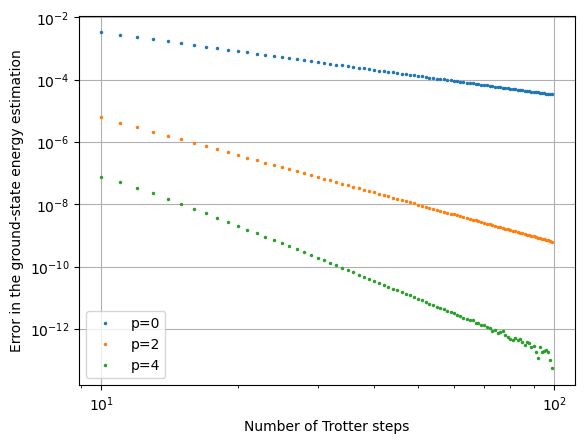

In [138]:
Ns = np.arange(10,100)

for p in range(0,6,2):

    if p==0: res = np.array([correct_energies(5*N,p) for N in Ns])
    elif p==2: res = np.array([correct_energies(3*N,p) for N in Ns])
    elif p==4: res = np.array([correct_energies(N,p) for N in Ns])
    energies, energies_corrected = res[:,0], res[:,1]
    energies_corrected -= energies

    print(linear_regression(np.log(Ns), np.log(np.abs(energies_corrected))))
    plt.plot(Ns,np.abs(energies_corrected),'o', label=f'p={p}',markersize=1.5)

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Number of Trotter steps')
plt.ylabel('Error in the ground-state energy estimation')
plt.legend()
plt.savefig('trotter.pdf')
plt.show()

[] 

[1.]
Success!
-1.994665888859044
[[1.         1.        ]
 [0.5        0.25      ]
 [0.33333333 0.11111111]] 

[ 0.5 -4.   4.5]
Success!
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-4.037812264538359Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

[[1.         1.         1.         1.        ]
 [0.5        0.25       0.125      0.0625    ]
 [0.33333333 0.11111111 0.03703704 0.01234568]
 [0.25       0.0625     0.015625   0.00390625]
 [0.2        0.04       0.008      0.0016    ]] 

[ 4.16666667e-02 -2.66666667e+00  2.02500000e+01 -4.26666667e+01
  2.60416667e+01]
Success!
-6.042682

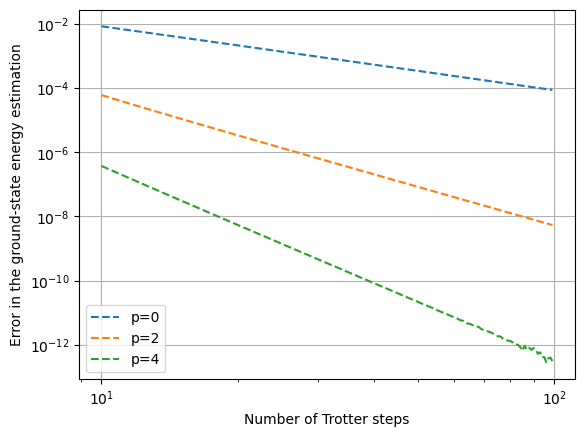

In [28]:
def correct_energies_compute_lambdas_once(Ns,p):
    """p: order of correction"""
    
    deltas = np.array([
        [1/q**k for k in range(1,p+1)] for q in range(1,p+2)
        # [1/delta_t**k for k in range(2,p+1,2)] for delta_t in delta_ts
    ])
    # for j in range(deltas.shape[1]): deltas[:,j] /= deltas[0,j]
    print(deltas,'\n')
    meet_constraints = False
    while not meet_constraints:
        lambdas, meet_constraints = find_linear_depenpency_coefficients(deltas)
    print(lambdas)
    print('Success!')
    assert meet_constraints
    
    # energies_approxs = []
    # for i in range(1,max(Ns)*(p+2)):
    #     energies, energies_approx = compute_energies(Ns[i])
    #     energies_approxs.append(energies_approx)
    # energies_approxs = np.array(energies_approxs)

    all_energies = []
    all_energies_corrected = []
    for N in Ns:
        Ns_for_algo = np.arange(1,p+2)*N
        # Ns_for_algo = [N//q for q in range(1,p+2)]
        energies_approxs = []
        for i in range(len(Ns_for_algo)):
            energies, energies_approx = compute_energies(Ns_for_algo[i])
            energies_approxs.append(energies_approx)
        energies_approxs = np.array(energies_approxs)
        energies_corrected = energies_approxs @ lambdas
        all_energies.append(energies)
        all_energies_corrected.append(energies_corrected)

    return np.array(all_energies), np.array(all_energies_corrected)


Ns = np.arange(10,100)

for p in range(0,6,2):

    energies, energies_corrected = correct_energies_compute_lambdas_once(Ns,p)
    energies_corrected -= energies

    print(linear_regression(np.log(Ns), np.log(np.abs(energies_corrected))))
    plt.plot(Ns,np.abs(energies_corrected),'--', label=f'p={p}')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Number of Trotter steps')
plt.ylabel('Error in the ground-state energy estimation')
plt.legend()
plt.show()

0.01053805127536167Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



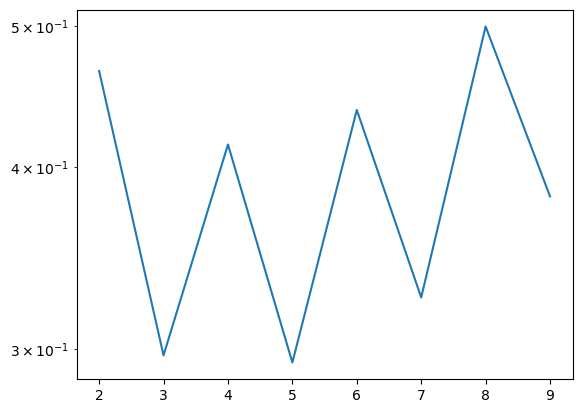

In [163]:
def compute_lambdas(p, which=0):
    if which==0: deltas = np.array([
        [1/q**k for k in range(1,p+1)] for q in range(1,p+2)
    ])
    elif which==1: deltas = np.array([
        [1/q**k for k in range(1,p+1)] for q in range(-p//2,-p//2+p+2) if q!=0
    ])
    elif which==2: deltas = np.array([
        [1/q**k for k in range(1,p+1)] for q in range(1,5*p)
    ])
    elif which==3: deltas = np.array([
        [1/q**k for k in range(1,p+1)] for q in range(-p,p+2) if q!=0
    ])
    # for j in range(deltas.shape[1]): deltas[:,j] /= deltas[0,j]
    # print(deltas,'\n')
    meet_constraints = False
    while not meet_constraints:
        lambdas, meet_constraints = find_linear_depenpency_coefficients(deltas)
    assert meet_constraints
    assert np.allclose(sum(lambdas),1)
    return lambdas

ps = np.arange(2,10)
ys = [max(compute_lambdas(p,which=3)) for p in ps]
print(linear_regression(ps, np.log(ys)))
plt.yscale('log')
plt.plot(ps,ys)
plt.show()

In [11]:
def correct_energies(N,p,which=0):
    """p: order of correction"""

    if p==0: return compute_energies(N)

    if which==0: Ns = np.arange(1,p+2)*N
    elif which==1: Ns = np.array([q for q in range(-p//2,-p//2+p+2) if q!=0])*N
    elif which==2: Ns = np.array([q for q in range(-5*p,5*p+2) if q!=0])*N
    # Ns = np.arange(N,N+p+1)
    # Ns = np.arange(N-p-1,N)*10
    delta_ts = T/Ns
    energies_approxs = []
    for i in range(len(Ns)):
        energies, energies_approx = compute_energies(Ns[i])
        energies_approxs.append(energies_approx)
    energies_approxs = np.array(energies_approxs)

    deltas = np.array([
        [delta_t**k for k in range(1,p+1)] for delta_t in delta_ts
        # [1/delta_t**k for k in range(2,p+1,2)] for delta_t in delta_ts
    ])
    for j in range(deltas.shape[1]): deltas[:,j] /= deltas[0,j]
    # print(deltas,'\n')
    meet_constraints = False
    while not meet_constraints:
        lambdas, meet_constraints = find_linear_depenpency_coefficients(deltas)

    assert meet_constraints
    energies_corrected = energies_approxs @ lambdas
    return energies, energies_corrected

-2.0007231878377123Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-4.005232975586332Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

-6.025899251575952Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



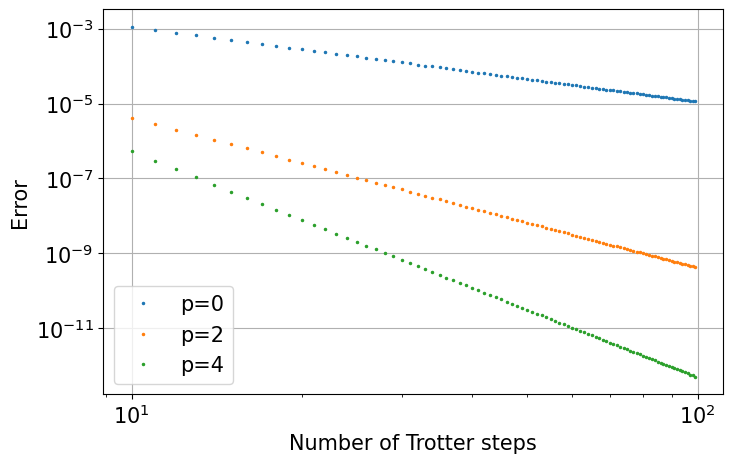

In [13]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,5))

Ns = np.arange(10,100)

for p in range(0,6,2):

    if p==0: res = np.array([correct_energies(3*N,p,which=1) for N in Ns])
    elif p==2: res = np.array([correct_energies(2*N,p,which=1) for N in Ns])
    elif p==4: res = np.array([correct_energies(N,p,which=1) for N in Ns])
    energies, energies_corrected = res[:,0], res[:,1]
    energies_corrected -= energies

    print(linear_regression(np.log(Ns), np.log(np.abs(energies_corrected))))
    plt.plot(Ns,np.abs(energies_corrected), 'o', label=f'p={p}',markersize=1.5)

# for p in range(0,6,2):

#     if p==0: res = np.array([correct_energies(3*N,p,which=2) for N in Ns])
#     elif p==2: res = np.array([correct_energies(2*N,p,which=2) for N in Ns])
#     elif p==4: res = np.array([correct_energies(N,p,which=2) for N in Ns])
#     energies, energies_corrected = res[:,0], res[:,1]
#     energies_corrected -= energies

#     print(linear_regression(np.log(Ns), np.log(np.abs(energies_corrected))))
#     plt.plot(Ns,np.abs(energies_corrected), 'o', label=f'p={p}',markersize=1.5)
    
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Number of Trotter steps')
plt.ylabel('Error')
plt.legend()
plt.savefig('trotter.pdf')
plt.show()